## **Rapport d'exploration, de data visualisation et de pre processing des données**

### *Pré Requis*

In [ ]:
#install wordcloud et install nltk pour import du stopwords
##!pip install wordcloud
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

### *Import des fichiers*

In [ ]:
# Open a session: initialize a few practical constants, mount share drive
from google.colab import drive
import os.path

DRIVE_PATH = "/content/drive/Shareddrives/ds_nov22_cnt_rakuten"
CSV_FILE_DIR = os.path.join(DRIVE_PATH, "train_test/csv_files")
IMG_DIR = os.path.join(DRIVE_PATH, "train_test/images")
IMG_TRAIN_DIR = os.path.join(IMG_DIR, "image_train")

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load train CSV files
# Note: compared to the original X_train file, X_train_with_img_path.csv contains an extra column "image_path"
# That column gives the full path to the image of each product.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import random
import pickle
import os
X_train = pd.read_csv(os.path.join(CSV_FILE_DIR, "X_train_with_img_path.csv"), index_col=0)
y_train = pd.read_csv(os.path.join(CSV_FILE_DIR, "Y_train_CVw08PX.csv"), index_col=0)

## fusion des deux fichiers
X_y_train = X_train.join(y_train)

# "Copie de sauvegarde" pour pouvoir restaurer X_y_train rapidement en cas d'erreur dans la suite
X_y_train_brut = X_y_train

### *Exploration des données*

In [ ]:
## affichage des informations
X_y_train.info()
## des valeurs manquent sur le champs "description"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
 4   image_path   84916 non-null  object
 5   prdtypecode  84916 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 6.6+ MB


In [ ]:
## vérification du nombre de valeurs NaN
X_y_train.isna().sum()
## plus de 29 000 lignes avec description manquante soit près de 35% du jeu de données

designation        0
description    29800
productid          0
imageid            0
image_path         0
prdtypecode        0
dtype: int64

In [ ]:
## comptage des types produits
X_y_train["prdtypecode"].value_counts()

2583    10209
1560     5073
1300     5045
2060     4993
2522     4989
1280     4870
2403     4774
2280     4760
1920     4303
1160     3953
1320     3241
10       3116
2705     2761
1140     2671
2582     2589
40       2508
2585     2496
1302     2491
1281     2070
50       1681
2462     1421
2905      872
60        832
2220      824
1301      807
1940      803
1180      764
Name: prdtypecode, dtype: int64

### *Phase de Pre Processing*

**Labelisation des 'PrdTypeCode' :** cette étape a été réalisée dans un second temps après quelques 1eres analyses graphiques (word cloud, panel d'images) qui ont permis de constater que pour une meilleure lisibilité, une labelisation des prdtypecode était nécessaire.


In [ ]:
# Labelisation des PrdTypeCode avec l'ajout d'une nouvelle colonne
X_y_train['Labels'] = X_y_train['prdtypecode']
X_y_train['Labels'] = X_y_train['Labels'].astype(str)
X_y_train['Labels'].replace({'2583':'Accessoires piscine et spa','1560':'Mobilier intérieur','1300':
'Modélisme','2060':'Eclairage et décoration','2522':'Papeterie','1280':'Jouets','2403':'Magazines et revues','2280':'Archives journaux et presse',
'1920':'Linge de maison','1160':'Cartes à échanger','1320':'Puericulture', '10':'Livres occasions','2705':'Livres',
'1140':'Figurines','2582':'Décorations ext. et accessoires','40':'jeux videos','2585':'Bricolage, jardinage','1302':'Loisirs extérieur',
'1281':'Jeux de société','50':'Loisirs intérieur','2462':'Acc. jeux vidéos, Consoles et jeu','2905':'Jeux en téléchargement',
'60':'Console de jeu vintage','2220':'Animalerie','1301':'Accessoires enfants','1940':'Alimentation','1180':'Jeux de rôle et jeux de figurines'}, inplace=True)


**Phase de nettoyage des données :** retrait des données manquantes, fusion des champs descriptions et designations, retrait des caractères spécifiques et des balises html, traduction des textes dans une seule et même langue.

In [ ]:
#Conservation d'une copie de X_y_train avant modification pour graphique de distribution des classes et des NAs
X_y_train_origine = X_y_train

# remplacement des NaN par des champs à vide
X_y_train = X_y_train.fillna('')

# conversion du Dataframe en string
X_y_train=X_y_train.astype("str")

# fusion des champs description et designation
# On ajoute dans une nouvelle colonne la description et la designation de manière fusionnée
X_y_train["design_describe"] = [(x + " " + y).strip() for x,y in zip(X_y_train["designation"],X_y_train["description"])]

# Nettoyage des caractères spéciaux/accents/etc dans design_describe :
# peut être utile pour la normalisation et le traitement des données textuelles dans les modèles d'apprentissage automatique.
X_y_train["design_describe"] = X_y_train["design_describe"].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# HTML : retrait des balises (mais conservation du texte qu'elles contiennent) avec BeautifulSoup
#      + décodage des chaînes type "&XXX;" en caractères avec la librairie html
import html
from bs4 import BeautifulSoup
X_y_train["design_describe"] = X_y_train["design_describe"].apply(
    lambda text: html.unescape(BeautifulSoup(text, 'html.parser').get_text())
)

# Une inspection avec le pattern d'expression régulière "<[a-z][^>]*$" montre que quelques balises *incorrectes* persistent
# Il s'agit de balises "br", "strong", "span", "img" et "a" bien initialisées avec un "<", mais soit sans ">", soit avec un "<" à la place.
# Traitons-les une fois pour toute en les remplaçant par des espaces.
import re
X_y_train["design_describe"] = X_y_train["design_describe"].apply(lambda txt: re.sub("<(br<|strong<|br|strong|span|img|a)", " ", txt, flags=re.IGNORECASE))

# affichage des 1eres lignes
display(X_y_train.head())

# vérification qu'il n'y ait plus de valeurs manquantes
display(X_y_train.isna().sum())


<ipython-input-14-c06ae2f5fb85>:23: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda text: html.unescape(BeautifulSoup(text, 'html.parser').get_text())


,designation,description,productid,imageid,image_path,prdtypecode,Labels,design_describe
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,,3804725264,1263597046,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,10,Livres occasions,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,,436067568,1008141237,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,2280,Archives journaux et presse,Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,50,Loisirs intérieur,Grand Stylet Ergonomique Bleu Gamepad Nintendo...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,,50418756,457047496,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,1280,Jouets,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,2705,Livres,La Guerre Des Tuques Luc a des idées de grande...


designation        0
description        0
productid          0
imageid            0
image_path         0
prdtypecode        0
Labels             0
design_describe    0
dtype: int64

### *Phase de Traduction*

In [ ]:
#Installation des traducteurs
!pip install googletrans
!pip install deep-translator
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 5.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=2ba3240b207b111e54fb89e1c5f329f1b37d4aabdd3dbc4a0d2129f72c541354
  Stored in directory: /root/.cache/pip/wheels/27/f3/32/d4859d40071f07a5df0ab6fdc0076e78a8a786625dde2b4b2f
Successfully built googletrans
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstal

In [ ]:
#Lancement de la traduction
import pandas as pd
from deep_translator import GoogleTranslator
from langdetect import detect
import time

def translate_batch(dataframe, column, start_index, batch_size):
    translated_descriptions = []

    for index in range(start_index, start_index + batch_size):
        if index >= len(dataframe):
            break

        original_text = dataframe.iloc[index][column]

        if original_text:
            translated_text = translate_text(original_text)
        else:
            translated_text = ""

        translated_descriptions.append(translated_text)

    return translated_descriptions

def split_text(text, max_length=1500):
    words = text.split(' ')
    split_texts = []
    current_text = ''

    for word in words:
        if len(current_text) + len(word) + 1 > max_length:
            split_texts.append(current_text)
            current_text = ''
        current_text += f'{word} '

    if current_text:
        split_texts.append(current_text)

    return split_texts

def translate_text(text, source='auto', target='fr'):
    detected_language = detect(text)

    if detected_language == 'fr':
        return text

    splitted_texts = split_text(text)
    translated_parts = []

    for part in splitted_texts:
        translated_text = GoogleTranslator(source=source, target=target).translate(part)
        if translated_text is None:
            translated_text = ""  # Utilisez une chaîne vide si la traduction échoue ou retourne None
        translated_parts.append(translated_text)

    return ' '.join(translated_parts)  # Retourne les parties traduites combinées

# Gestion des paquets
batch_size = 1000
# démarrage à partir de la ligne 0
start_index = 0
num_elements = 84916
num_batches = (num_elements + batch_size - 1) // batch_size

#création d'un dataframe pour stocker les traductions
translated_df = pd.DataFrame(columns=["translated_description"])
start_time = time.time()

remaining_batches = num_batches - (start_index // batch_size)
if remaining_batches > 0:
    for _ in range(remaining_batches):
        translated_descriptions = translate_batch(X_y_train, "design_describe", start_index, batch_size)
        start_index += batch_size
        temp_df = pd.DataFrame(translated_descriptions, columns=["translated_description"])
        translated_df = translated_df.append(temp_df, ignore_index=True)

    end_time = time.time()

    time_per_batch = (end_time - start_time) / remaining_batches
    print(f"Temps pour un lot : {time_per_batch} secondes")

    estimated_total_time = time_per_batch * num_batches
    print(f"Temps estimé pour tous les lots : {estimated_total_time} secondes")
else:
    print("Aucun lot restant à traiter.")

#vérification des dimensions
translated_df.shape

# Sauvegarder le DataFrame pour sauvegarder toutes les traductions
translated_df.to_csv("/content/drive/Shareddrives/ds_nov22_cnt_rakuten/traduction_colonne_design_describe.csv", index=False)

<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  translated_df = translated_df.append(temp_df, ignore_index=True)
<ipython-input-11-f578618815a7>:75: FutureWarning: The f

Temps pour un lot : 235.997056871302 secondes
Temps estimé pour tous les lots : 20059.74983406067 secondes


In [ ]:
#Emplacement du csv telechargé pour creer une copie locale
import os
current_working_directory = os.getcwd()
file_name = 'traduction_colonne_design_describe.csv'
file_path = os.path.join(current_working_directory, file_name)
print(f"Le fichier CSV a été stocké à l'emplacement suivant: {file_path}")

Le fichier CSV a été stocké à l'emplacement suivant: /content/traduction_colonne_design_describe.csv


In [ ]:
# import du nouveau fichier des traductions
translated_df=pd.read_csv('/content/drive/Shareddrives/ds_nov22_cnt_rakuten/traduction_colonne_design_describe.csv')
# Ajout de translated_df dans X_y_train pour créer un csv contenant toutes les données nécéssaires
X_y_train["designe_decrit"] = translated_df
# On enregistre les traductions et la data de base dans un nouveau document csv,
X_y_train.to_csv("/content/drive/Shareddrives/ds_nov22_cnt_rakuten/df_avec_traduction.csv",index=False)

#Trouvons le chemin qui contient ce nouveau csv
import os
current_working_directory = os.getcwd()
csv_file_path = os.path.join(current_working_directory, "df_avec_traduction.csv")
print(f"Le fichier CSV a été sauvegardé à : {csv_file_path}")

#Pour la partie machine learning, nous utiliserons le nouveau csv("df_avec_traduction.csv")
#contenant, en plus la colonne "designe_decrit".


Le fichier CSV a été sauvegardé à : /content/df_avec_traduction.csv


In [ ]:
# import du nouveau fichier complet
df =pd.read_csv('/content/drive/Shareddrives/ds_nov22_cnt_rakuten/df_avec_traduction.csv')
df.head(2)

,designation,description,productid,imageid,image_path,prdtypecode,Labels,design_describe,designe_decrit
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,10,Livres occasions,Olivia: Personalisiertes Notizbuch / 150 Seite...,Olivia : Carnet personnalisé / 150 pages / Dot...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,/content/drive/Shareddrives/ds_nov22_cnt_rakut...,2280,Archives journaux et presse,Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...,Journal Des Arts (Le) N 133 Du 28/09/2001 - L'...


## ***Représentations graphiques***

### *Word Cloud par classe*

**Application du Word Cloud :** Il permet de percevoir très rapidement quels sont les mots les plus fréquents au sein de texte ou corpus de texte.
Il nécessite l'installation au préalable de la fonctionnalité Word Cloud et de la bibliothèque nltk pour l'utilisation du stopwords, qui a pour objectif de retirer les 'mots vides' c'est à dire qui n'ont pas de significations dans l'analyse.

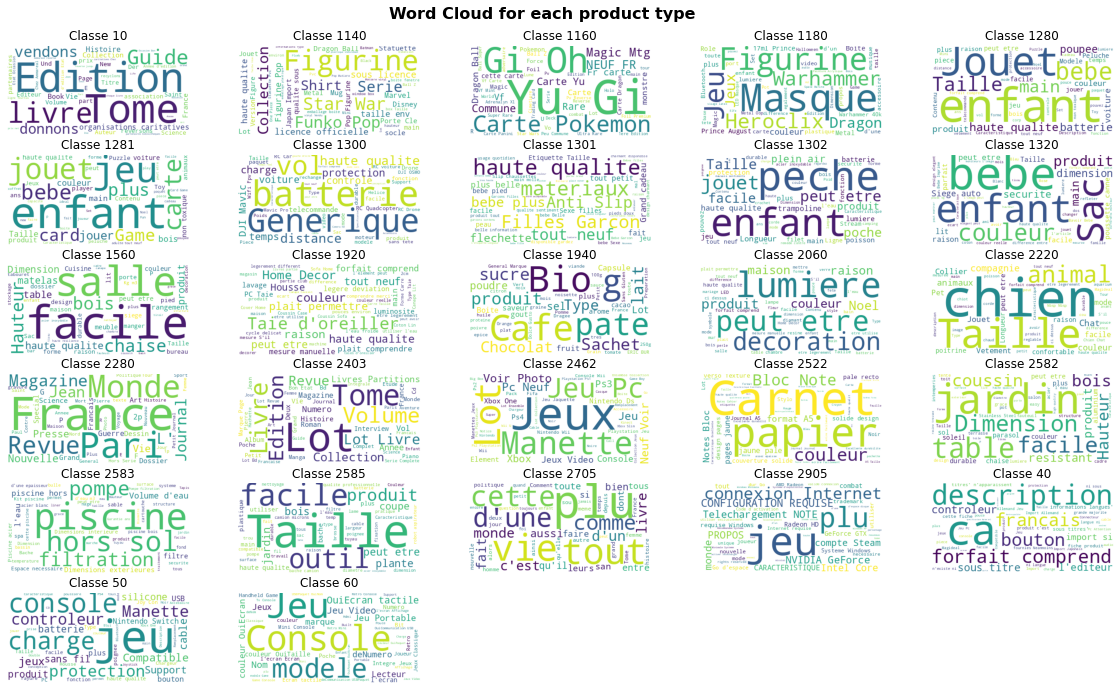

In [ ]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.colors import LogNorm
from nltk.corpus import stopwords

# Initialisation des variables
product_type_codes = X_y_train["prdtypecode"].drop_duplicates().sort_values()
n_classe = product_type_codes.count()
imgs_per_code= 5
subfig_side = 2
fig = plt.figure(figsize=(imgs_per_code * 4, n_classe * subfig_side))
overall_title = fig.suptitle("Word Cloud for each product type", fontsize=16, fontweight="bold", y=0.89)

# Initialisation de la variable des mots vides et ajout des balises html
stop_words = set(stopwords.words(['english', 'french']))
exclure_mots = ['x', 'cm', 'h', 'mm']
stop_words.update(exclure_mots)

# Création du modèle word cloud
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words, max_words = 50)

# Création d'un graphique par classe
i = 0
for code in product_type_codes.sort_values():
  i+=1
  text = " ".join(X_y_train[X_y_train["prdtypecode"] == code]["design_describe"])
  wordcloud.generate(text);
  if i <= n_classe:
    fig.add_subplot(n_classe, imgs_per_code, i).set_title("Classe " + str(code))
  plt.plot()
  plt.imshow(wordcloud);
  plt.axis("off");
plt.show();

**Interprétation :**

Cette représentation par classe permet de mettre en évidence les mots les plus fréquents au sein de cette catégorie. Parmi les mots les plus récurrents, on en retrouve certains comme "eau", "piscine", "taille", etc., en lien avec la catégorie '2583' la plus représentée : "Accessoires de piscine"

### *Panel d'images*

In [ ]:
# execution en 10minutes
product_type_codes = X_y_train["prdtypecode"].drop_duplicates().sort_values()

# Display a gallery of product images, with a row per product type code
import matplotlib.pyplot as plt

# One row per type code and imgs_per_code columns
n_codes = product_type_codes.count()
imgs_per_code = 8
# Each image will be nested in a square cell, subfig_side x subfig_side in size
subfig_side = 4

fig = plt.figure(figsize=(imgs_per_code * subfig_side, n_codes * subfig_side))
overall_title = fig.suptitle("A few images for each product type", fontsize=20, fontweight="bold", y=0.885)
i_fig = 0
for code in product_type_codes.sort_values():
  start_column = True
  # For predictable results, either add "random_state=XX" to method "sample", or use method "head" instead
  for img_path in X_y_train[X_y_train["prdtypecode"] == code]["image_path"].sample(imgs_per_code):
    i_fig += 1
    ax = fig.add_subplot(n_codes, imgs_per_code, i_fig)
    ax.set_xticks([])
    ax.set_yticks([])
    if start_column:
      code_title = ax.set_ylabel("Type code {}".format(code), fontsize=16)
    img = plt.imread(img_path)
    ax.imshow(img)

    start_column = False


Output hidden; open in https://colab.research.google.com to view.

**Interprétation :**

Cette représentation permet de visualiser la correspondance des classes de produits par les images. Certaines catégories comme la catégorie 10, Livre d’occasion et 1301, Accessoires enfants, sont difficilement classifiables.


### *Distribution des classes*

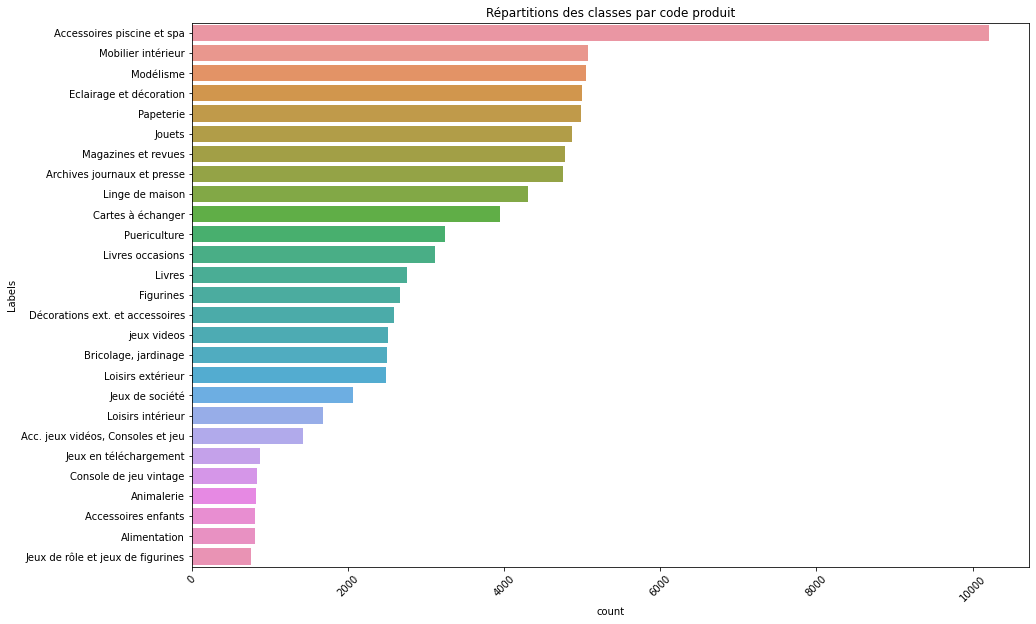

In [ ]:
# Affichage de la distribution des classes
plt.figure(figsize = (15,10))
sns.countplot(y=X_y_train['Labels'], order=X_y_train['Labels'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Répartitions des classes par code produit');


**Interprétation :**

On constate un déséquilibre prononcé dans la représentation des différents types de produit. Le type n°2853, le plus représenté, compte environ 13 fois plus de produits que le type le moins représenté (n°1180).

### *Distribution des classes et des NAs*



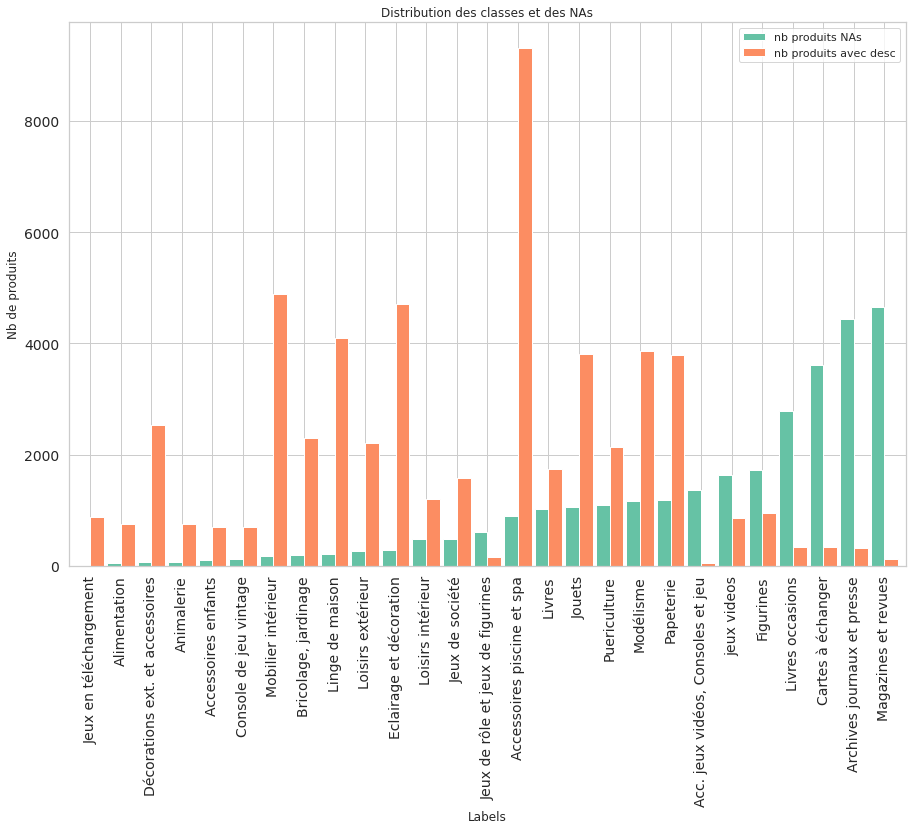

In [ ]:
# comptage du nombre de produits avec valeurs manquantes
class_description = pd.DataFrame(X_y_train_origine.groupby('Labels')['description'].apply(lambda x: x.isna().sum()))
class_description = class_description.rename(columns={'Labels':'Classes','description':'nb produits NAs'})
# comptage du nombre de produits avec valeurs renseignées
class_description['nb produits avec desc']=X_y_train_origine.groupby('Labels')['description'].apply(lambda x: x.notna().sum())

# Afficher la répartition des produits avec description ou sans
sns.set_theme(style='whitegrid', palette='Set2')
ax = class_description.sort_values(by='nb produits NAs').plot.bar(width = 0.9, rot=90, figsize=(15, 10), ylabel='Nb de produits',sort_columns=True, title ='Distribution des classes et des NAs', fontsize=14)



**Interprétation :**

Il est clair que certaines classes de produits sont plus touchées que d'autres par les descriptions manquantes.

Peut-être que certains produits sont davantage vendus par des vendeurs indépendants qui ne prennent pas le temps de saisir une description détaillée. Souvent, l'essentiel des informations se trouve dans le champ 'designation'.

### *Distribution du nombre de caractères designatifs selon la catégorie*

<Figure size 1080x720 with 0 Axes>

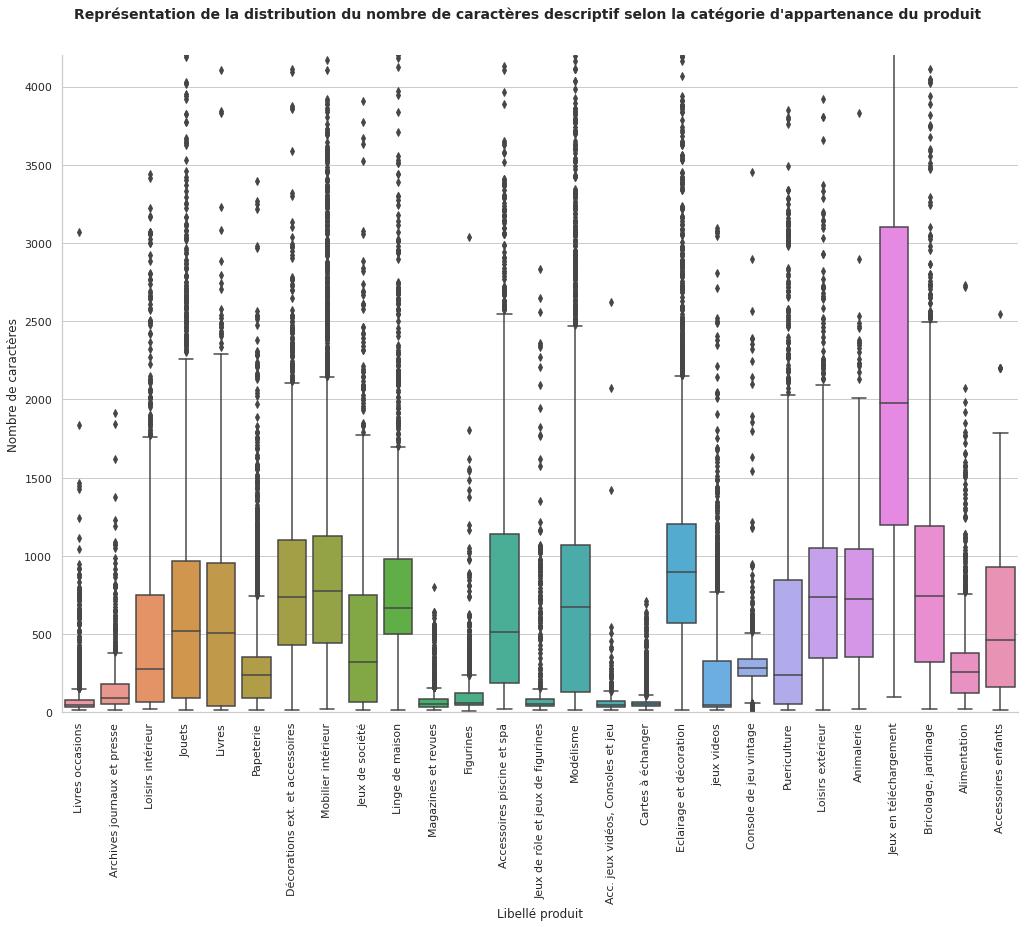

In [ ]:
# Création d'une nouvelle colonne pour compter le nombre de caractères
X_y_train["nombre_de_caracteres"] = X_y_train["design_describe"].apply(lambda x: len(x))

# Creer un boxplot d'abscisse Libellé produit et d'ordonnée nombre_de_caracteres
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.figure(figsize=(15,10));
sns.set(style="whitegrid");

# Création de la figure avec un axe y catégoriel et un axe x quantitatif
g = sns.catplot(data=X_y_train, x='Labels', y='nombre_de_caracteres', kind='box', height=10, aspect=1.5);
g.set(ylim=(0, 4200));

# Personnalisation de la figure
g.set_axis_labels("Libellé produit","Nombre de caractères");
g.set_titles("Représentation de la distribution du nombre de caractères descriptif selon la catégorie d'appartenance du produit, {col_name}");
g.set_xticklabels(rotation=90);

# Récupération de l'objet figure
fig = g.fig;

# Modification du titre de la figure
fig.suptitle("Représentation de la distribution du nombre de caractères descriptif selon la catégorie d'appartenance du produit", y=1.05,fontweight="bold",fontsize=14);

# Affichage de la figure
plt.show();

**Interprétation :**

Cette figure permet de visualiser le nombre de caractères descriptif selon la catégorie d'appartenance du produit.
A titre indicatif, les catégories de produits les moins décrits, sont :
*   10 - Des livres
*   2403 - Des lots de livres et de magazines
*   1140 - Des figurines
*   1180 - Des petits objets de collection
*   2462 - Des jeux vidéos de console
*   1160 - Des cartes de jeux

Et la catégorie de produits la plus décrite est :     

*   2905 - Des jeux PC



### *Taux de produits par catégorie*

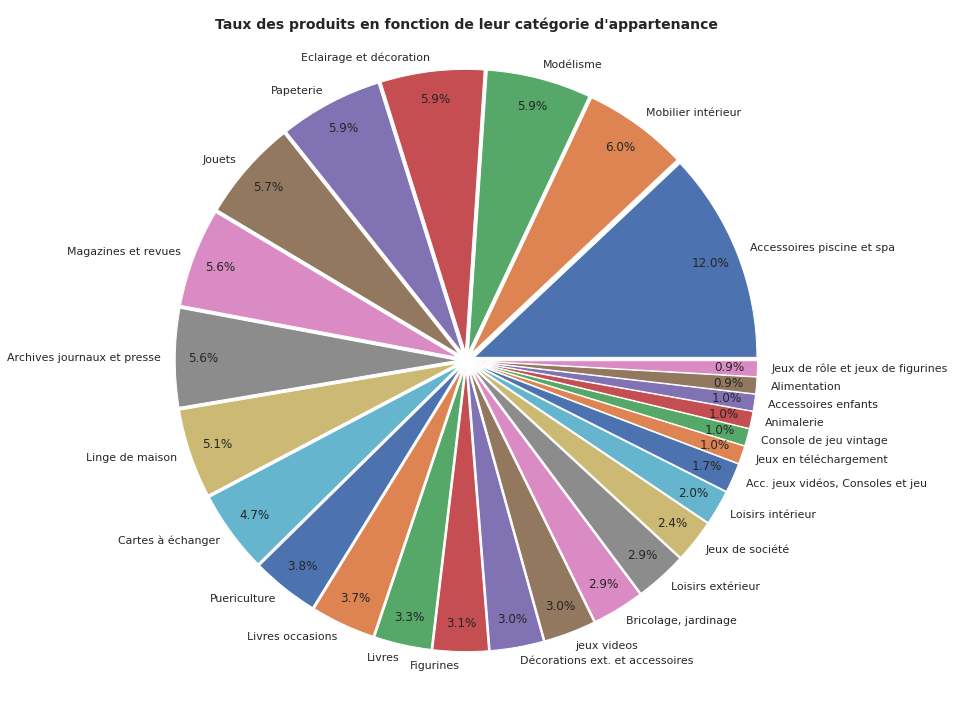

In [ ]:
# Distribution des produits
counts = X_y_train['Labels'].value_counts()

# Création du Diagramme circulaire
plt.figure(figsize=(13, 13))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%',pctdistance=0.9,labeldistance=1.05, explode = [.03]*len(counts.values))
plt.title("Taux des produits en fonction de leur catégorie d'appartenance",y=0.96,fontweight="bold",fontsize=14)

# Affichage du diagramme
plt.show()

**Interprétation :**

Cette figure permet de visualiser le taux des produits en fonction de leur catégorie d'appartenance.
Nous pouvons remarquer que les produits de la catégorie ayant le plus de descriptions représentent 1% des produits de cette base de données.


D'ailleurs, la catégorie ayant le plus de produit dans son répertoire est la 2583 (piscines et accessoires) avec 12% des éléments de cette base de données. Cette dernière catégorie semble presenter une description de longueur standard par rapport à l'ensemble des catégories observées.